## Подготовка данных для обучение (формирование выборок)

Брали рандомным образом по 800 картинок в выборку, сделали 30 выборок.
В среднем каждая картинка попала в выборку 800/8000 * 30 = 3 раза (в разных аугментациях).
Вероятность что определенная картинка ни в одну выборку не попала 0.9 ^ 30 = 0.04

### Импорт библиотек

In [185]:
import numpy as np
import random
import os
import time

import cv2 as cv
import matplotlib.pyplot as plt 

import albumentations as A

### Анализ данных

In [186]:
# Пути к данным
dataset_path = "/home/jupyter/work/resources/train/"
images_path = "/home/jupyter/work/resources/train/images"
anns_path = "/home/jupyter/work/resources/train/mask"
test_path = "/home/jupyter/work/resources/test"

In [187]:
# Создадим списки файлов с путями к ним
img_names= [ os.path.join(images_path, file_name) for file_name in os.listdir(images_path)]
ann_names = [ os.path.join(anns_path, file_name) for file_name in os.listdir(anns_path)]
test_names= [ os.path.join(test_path, file_name) for file_name in os.listdir(test_path)]

==================================================================================

In [183]:
# Проверим что каждой картинке соответствует ее размеченный вариант
error_count = 0
cur_time = time.time()
for file_name in os.listdir(images_path):
    if  not file_name in os.listdir(anns_path):
        print("Не нашли аннотацию для файла {}".format(file_name))
        error_count += 1
        
if error_count == 0:
    print("Все аннотации на месте")
else:
    print("Всего не нашли аннотаций для {} файлов".format(error_count))   
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

Все аннотации на месте
Время выполнения: 24.87c


In [ ]:
# Посмотрим каких размеров картинки в датасете
dict = {}
cur_time = time.time()
for file_name  in img_names:
    img = cv.imread(file_name)
    if str(img.shape) in dict.keys():
        dict[str(img.shape)] += 1
    else:
        dict[str(img.shape)] = 1
    
print("Имеем {} картинок".format(len(img_names)))
print("Встречаются размеры: {}".format(dict))
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

In [ ]:
# Посмотрим каких размеров картинки для теста
dict = {}
cur_time = time.time()
for file_name  in test_names:
    img = cv.imread(file_name)
    if str(img.shape) in dict.keys():
        dict[str(img.shape)] += 1
    else:
        dict[str(img.shape)] = 1
    
print("Имеем {} тестовых картинок".format(len(test_names)))
print("Встречаются размеры: {}".format(dict))
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

In [ ]:
# Соберем информацию о классах разметки сегментации
ann_set = np.array([])
cur_time = time.time()
for file_name  in ann_names:
    ann = cv.imread(file_name)
    curr_set = np.unique(ann)
    ann_set = np.union1d(ann_set, curr_set)
    
print("Получили классы разметки: {}".format(ann_set))
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

**0 фон**

**6 прочие пути**
 
**7 главный путь**

**10 подвижной состав**

In [142]:
# Проверим нет ли файлов без разметки (где в маске только класс 0)
error_list = []
cur_time = time.time()

for file_name  in ann_names:
    ann = cv.imread(file_name)
    curr_set = np.unique(ann)

    if len(curr_set)==1:
        error_list.append(file_name)
        print("В файле {} только класс {}".format(file_name, curr_set))
        
if len(error_list)==0:
    print("Файлов без разметки (кроме фона) не найдено")
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

В файле /home/jupyter/work/resources/train/mask/img_0.7543924316001528.png только класс [0]
Время выполнения: 1097.48c


In [148]:
# найденные файлы без разметки удалим
for file_name in error_list:
    print(file_name)
    print(os.path.join(images_path, os.path.basename(file_name)))
    os.remove(file_name)
    os.remove(os.path.join(images_path, os.path.basename(file_name)))
# списки файлов пересоздадим
img_names= [ os.path.join(images_path, file_name) for file_name in os.listdir(images_path)]
ann_names = [ os.path.join(anns_path, file_name) for file_name in os.listdir(anns_path)]


/home/jupyter/work/resources/train/mask/img_0.7543924316001528.png
/home/jupyter/work/resources/train/images/img_0.7543924316001528.png


==================================================================================

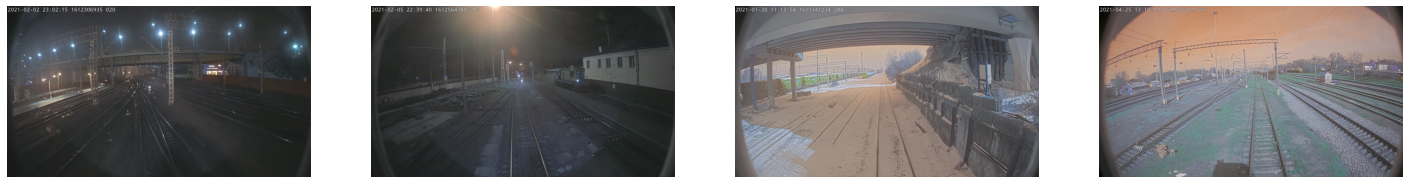

In [5]:
# Посмотрим n оригинальных случайных картинок из тренировочной выборки
n = 4
fig, axs = plt.subplots(1, n, figsize=(25, 10))  

n_files = random.choices(img_names, k=n) 

for i,file in enumerate(n_files):                               
  image = cv.imread(file)
  axs[i].axis('off')
  axs[i].imshow(image)             

plt.show()   

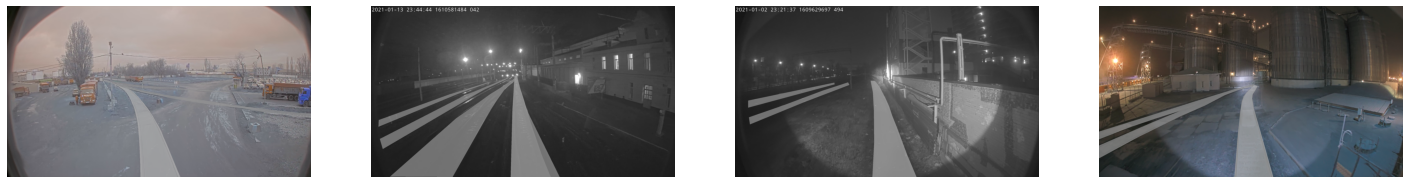

In [154]:
# Посмотрим n оригинальных случайных картинок из тренировочной выборки c наложением маски
# (маску визуалилируем с прозрачностью)
n = 4
fig, axs = plt.subplots(1, n, figsize=(25, 10))  

n_files = random.choices(img_names, k=n) 

for i,file in enumerate(n_files):                               
  image = cv.imread(file)
  ann = cv.imread(os.path.join(anns_path, os.path.basename(file)), 0) * 25
    
  image[:, :, 0] = np.where(ann == 0, image[:, :, 0], image[:, :, 0] * 0.3 + ann*0.7)
  image[:, :, 1] = np.where(ann == 0, image[:, :, 1], image[:, :, 1] * 0.3 + ann*0.7)
  image[:, :, 2] = np.where(ann == 0, image[:, :, 2], image[:, :, 2] * 0.3 + ann*0.7)

  
  axs[i].axis('off')
  axs[i].imshow(image)             

plt.show()   

### Функции

In [188]:
# Функция преобразования аннотации в one hot encoding
# classes = [0, 6, 7, 10]
def mask_to_ohe(ann_image, classes=[0, 6, 7, 10]):
    
    ones = np.ones((ann_image.shape[0], ann_image.shape[1], len(classes)),dtype = np.uint8)
    zeros = np.zeros((ann_image.shape[0], ann_image.shape[1], len(classes)),dtype = np.uint8)
    
    result = zeros.copy()
    
    result[:, :, 0] = np.where(ann_image == 0, ones[:, :, 0], zeros[:, :, 0])
    result[:, :, 1] = np.where(ann_image == 6, ones[:, :, 1], zeros[:, :, 1])
    result[:, :, 2] = np.where(ann_image == 7, ones[:, :, 2], zeros[:, :, 2])
    result[:, :, 3] = np.where(ann_image == 10, ones[:, :, 3], zeros[:, :, 3])
    
    return result

In [189]:
# Функция преобразования аннотации из ohe в классы
def ohe_to_mask(ann_ohe, classes=[0, 6, 7, 10]):
    
    ones = np.ones((ann_ohe.shape[0], ann_ohe.shape[1]),dtype = np.uint8)
    zeros = np.zeros((ann_ohe.shape[0], ann_ohe.shape[1]),dtype = np.uint8)
    
    result = zeros.copy()    
    
    result = np.where(ann_ohe[:,:,0] == 1, ones * 0, result)
    result = np.where(ann_ohe[:,:,1] == 1, ones * 6, result)
    result = np.where(ann_ohe[:,:,2] == 1, ones * 7, result)
    result = np.where(ann_ohe[:,:,3] == 1, ones * 10, result)
    
    return result    

In [190]:
# Функция автокоррекции контраста
def autocontrast(img):
    # converting to LAB color space
    lab= cv.cvtColor(img, cv.COLOR_BGR2LAB)
    l_channel, a, b = cv.split(lab)
    
    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    result = cv.cvtColor(limg, cv.COLOR_LAB2BGR)
    
    return(result)

### Подготовка выборок

In [191]:
# Для выборок берем 8000 картинок, остальные оставим для тестов
img_names_for_np = img_names[:-202]
img_names_for_test = img_names[-202:]
print("Для выборок берем {} картинок".format(len(img_names_for_np)))
print("Для тестов оставили {} картинок".format(len(img_names_for_test)))

Для выборок берем 8000 картинок
Для тестов оставили 202 картинок


In [158]:
# Сохраним список файлов, оставленных для тестов
import pandas as pd
my_df = pd.DataFrame(img_names_for_test)
my_df.to_csv('/home/jupyter/work/resources/NIIAS-RZD/imgs_for_test.csv', index=False, header=False)

In [12]:
#!c1.8
# Подготавливаем и сохраним N выборок
N = 30
# Путь для сохранения массивов
data_np_path = "/home/jupyter/work/resources/NIIAS-RZD/data_np"
start_from = 1  # нумерации файлов 

# Каждая выборка будет состоять из num_images картинок
num_images = 800

# Размеры, к которым приводим изображение
img_height = 432      # 216
img_width = 768       # 384        

# Сколько классов сегментации
classes = [0, 6, 7, 10] 

# Объявляем аугментацию
transform = A.Compose([
    A.Resize(height=img_height, width=img_width),
    A.HorizontalFlip(p=0.5),    
    A.OneOf([
        A.RandomCrop(int(img_height*0.5), int(img_width*0.5), p=1),  
        A.RandomCrop(int(img_height*0.75), int(img_width*0.75), p=1),    
        A.RandomCrop(int(img_height*0.9), int(img_width*0.9), p=1),
    ], p=0.9),
    A.Resize(height=img_height, width=img_width),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.OneOf([
        A.MotionBlur(blur_limit=15, p=1),
        A.Blur(blur_limit=15, p=1),
    ], p=0.2),
])


cur_time = time.time()
for n in range(N):
    print()
    print("Готовим выборку {}".format(n+1))
    
    images = []    
    anns = []
    
    # Выбираем из 8000 картинок
    random_files = random.choices(img_names_for_np, k=num_images)

    # 
    for file_name in random_files:
        # Берем картинку
        curr_image = cv.imread(file_name)

        # делаем предобработку (коррекцию контраста)
        curr_image = autocontrast(curr_image)        
        
        # Переходим к RGB
        curr_image = cv.cvtColor(curr_image, cv.COLOR_BGR2RGB)

        # сохраним оригинальные размеры картинки
#         curr_w = curr_image.shape[1]
#         curr_h = curr_image.shape[0]

        # делаем ресайз к целевым размерам
#         curr_image = cv.resize(curr_image, (img_width, img_height), interpolation=cv.INTER_AREA)

        # Берем аннотацию
        curr_ann = cv.imread(os.path.join(anns_path, os.path.basename(file_name)), 0)
    
        # делаем аугментацию
        transformed = transform(image=curr_image, mask=curr_ann)
        transformed_image = transformed['image']
        transformed_ann = transformed['mask']
     
        # переходим к диапазону 0 до 1 и отправляем картинку в список
        images.append(transformed_image / 255.)
  
        # классы аннотации переводим ohe и отправляем в список
        anns.append(mask_to_ohe(transformed_ann))
        
        # каждые 100 шагов 
        if len(images) % 100 == 0:
            print("Обработано {} из {} картинок".format(len(images), num_images)) 
        
        
    
    # Сохраним массивы
    images_np = np.array(images)
    anns_np = np.array(anns)
    
    file_number = "%02d" % (start_from + n)
    file_np = os.path.join(data_np_path, 'data'+ file_number)

    print("Сохраняем выборку в {}".format(file_np))
    np.savez_compressed(file_np, a=images_np, b=anns_np)
    
    
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')


Готовим выборку 1
Обработано 100 из 800 картинок
Обработано 200 из 800 картинок
Обработано 300 из 800 картинок
Обработано 400 из 800 картинок
Обработано 500 из 800 картинок
Обработано 600 из 800 картинок
Обработано 700 из 800 картинок
Обработано 800 из 800 картинок
Сохраняем выборку в /home/jupyter/work/resources/NIIAS-RZD/data_np/data21

Готовим выборку 2
Обработано 100 из 800 картинок
Обработано 200 из 800 картинок
Обработано 300 из 800 картинок
Обработано 400 из 800 картинок
Обработано 500 из 800 картинок
Обработано 600 из 800 картинок
Обработано 700 из 800 картинок
Обработано 800 из 800 картинок
Сохраняем выборку в /home/jupyter/work/resources/NIIAS-RZD/data_np/data22

Готовим выборку 3
Обработано 100 из 800 картинок
Обработано 200 из 800 картинок
Обработано 300 из 800 картинок
Обработано 400 из 800 картинок
Обработано 500 из 800 картинок
Обработано 600 из 800 картинок
Обработано 700 из 800 картинок
Обработано 800 из 800 картинок
Сохраняем выборку в /home/jupyter/work/resources/NI

==================================================================================

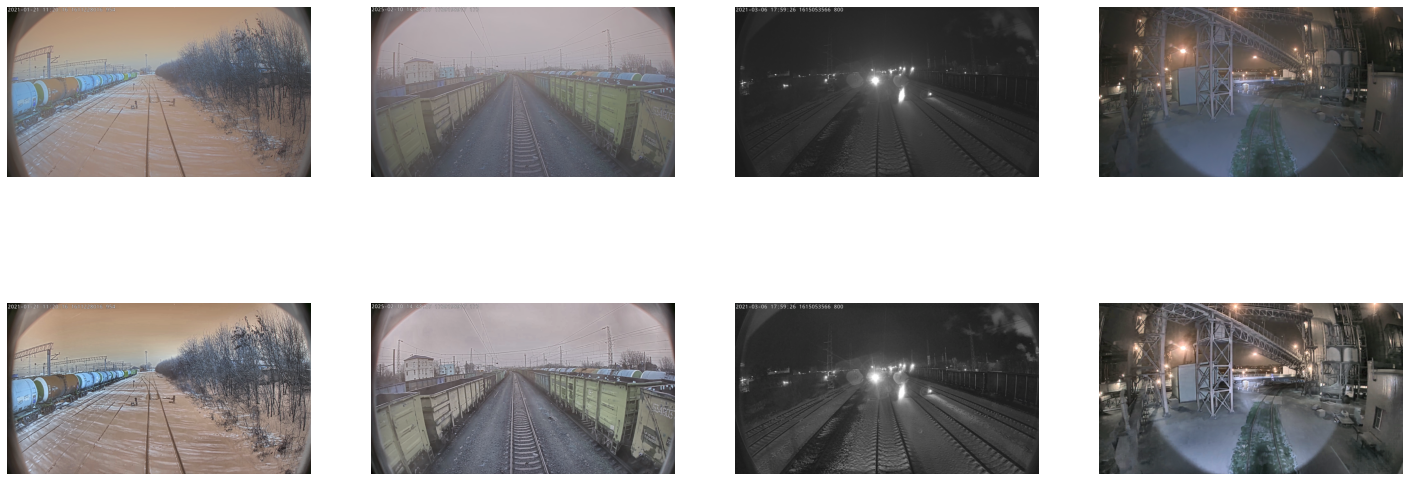

In [175]:
# Посмотрим как работает предобработка (автоконтраст)
n = 4
fig, axs = plt.subplots(2, n, figsize=(25, 10))  

n_files = random.choices(img_names, k=n) 

for i,file in enumerate(n_files):                               
  image = cv.imread(file)
  axs[0,i].axis('off')
  axs[0,i].imshow(image)

  image = autocontrast(image)
  axs[1,i].axis('off')
  axs[1,i].imshow(image)             

plt.show()  

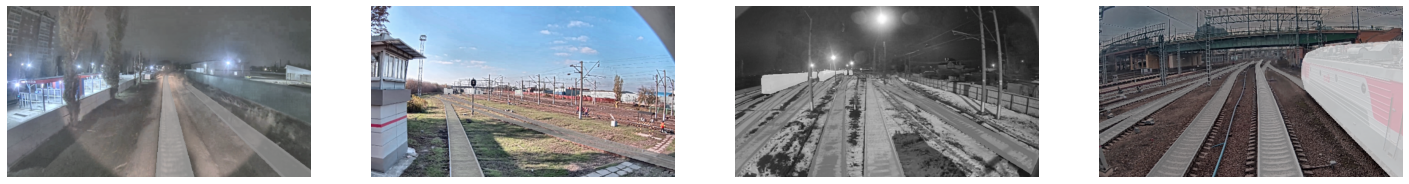

In [176]:
# Посмотрим несколько подготовленных картинок после предобработки и аугментации
n = 4
fig, axs = plt.subplots(1, n, figsize=(25, 10))  

for i in range(n): 
  
  idx = random.randrange(len(images))
  
  image = (images_np[idx] * 255).astype(np.uint8)
  ann = ohe_to_mask(anns_np[idx]) * 25
    
  image[:, :, 0] = np.where(ann == 0, image[:, :, 0], image[:, :, 0] * 0.3 + ann*0.7)
  image[:, :, 1] = np.where(ann == 0, image[:, :, 1], image[:, :, 1] * 0.3 + ann*0.7)
  image[:, :, 2] = np.where(ann == 0, image[:, :, 2], image[:, :, 2] * 0.3 + ann*0.7)

  
  axs[i].axis('off')
  axs[i].imshow(image)             

plt.show()   

### Подготовка дополнительных выборок

В выборки будут помещаться только те картинки, где есть подвижной состав (класс  10)

In [200]:
#!c1.8
# Подготавливаем и сохраним N выборок
N = 10
# Путь для сохранения массивов
data_np_path = "/home/jupyter/work/resources/NIIAS-RZD/data_np"
start_from = 51  # нумерации файлов 

# Каждая выборка будет состоять из num_images картинок
num_images = 800

# Размеры, к которым приводим изображение
img_height = 432      # 216
img_width = 768       # 384        

# Сколько классов сегментации
classes = [0, 6, 7, 10] 
# Обязательный класс
must_have = classes[3]

# Объявляем аугментацию
transform = A.Compose([
    A.Resize(height=img_height, width=img_width),
    A.HorizontalFlip(p=0.5),    
    A.OneOf([
        A.RandomCrop(int(img_height*0.5), int(img_width*0.5), p=1),  
        A.RandomCrop(int(img_height*0.75), int(img_width*0.75), p=1),    
        A.RandomCrop(int(img_height*0.9), int(img_width*0.9), p=1),
    ], p=0.9),
    A.Resize(height=img_height, width=img_width),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.OneOf([
        A.MotionBlur(blur_limit=15, p=1),
        A.Blur(blur_limit=15, p=1),
    ], p=0.2),
])


cur_time = time.time()
for n in range(N):
    print()
    print("Готовим выборку {}".format(n+1))
    
    images = []    
    anns = []
    
    counter = 0
    while counter < num_images:
        # Выбираем по одной картинке из 8000 
        file_name  = random.choice(img_names_for_np)

        # Cначала берем аннотацию
        curr_ann = cv.imread(os.path.join(anns_path, os.path.basename(file_name)), 0)
        
        # Пропускаем если нет нужного класса
        curr_set = np.unique(curr_ann)
        if must_have not in curr_set:
            continue
        
        # Берем картинку
        curr_image = cv.imread(file_name)

        # делаем предобработку (коррекцию контраста)
        curr_image = autocontrast(curr_image)        
        
        # Переходим к RGB
        curr_image = cv.cvtColor(curr_image, cv.COLOR_BGR2RGB)

        # сохраним оригинальные размеры картинки
#         curr_w = curr_image.shape[1]
#         curr_h = curr_image.shape[0]

        # делаем ресайз к целевым размерам
#         curr_image = cv.resize(curr_image, (img_width, img_height), interpolation=cv.INTER_AREA)
    
        # делаем аугментацию
        transformed = transform(image=curr_image, mask=curr_ann)
        transformed_image = transformed['image']
        transformed_ann = transformed['mask']
     
        # переходим к диапазону 0 до 1 и отправляем картинку в список
        images.append(transformed_image / 255.)
  
        # классы аннотации переводим ohe и отправляем в список
        anns.append(mask_to_ohe(transformed_ann))
        
        # каждые 100 шагов 
        if len(images) % 100 == 0:
            print("Обработано {} из {} картинок".format(len(images), num_images)) 
        
        # 
        counter += 1
    
    # Сохраним массивы
    images_np = np.array(images)
    anns_np = np.array(anns)
    
    file_number = "%02d" % (start_from + n)
    file_np = os.path.join(data_np_path, 'data'+ file_number)

    print("Сохраняем выборку в {}".format(file_np))
    np.savez_compressed(file_np, a=images_np, b=anns_np)
    
    
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')


Готовим выборку 1
Обработано 100 из 800 картинок
Обработано 200 из 800 картинок
Обработано 300 из 800 картинок
Обработано 400 из 800 картинок
Обработано 500 из 800 картинок
Обработано 600 из 800 картинок
Обработано 700 из 800 картинок
Обработано 800 из 800 картинок
Сохраняем выборку в /home/jupyter/work/resources/NIIAS-RZD/data_np/data51

Готовим выборку 2
Обработано 100 из 800 картинок
Обработано 200 из 800 картинок
Обработано 300 из 800 картинок
Обработано 400 из 800 картинок
Обработано 500 из 800 картинок
Обработано 600 из 800 картинок
Обработано 700 из 800 картинок
Обработано 800 из 800 картинок
Сохраняем выборку в /home/jupyter/work/resources/NIIAS-RZD/data_np/data52

Готовим выборку 3
Обработано 100 из 800 картинок
Обработано 200 из 800 картинок
Обработано 300 из 800 картинок
Обработано 400 из 800 картинок
Обработано 500 из 800 картинок
Обработано 600 из 800 картинок
Обработано 700 из 800 картинок
Обработано 800 из 800 картинок
Сохраняем выборку в /home/jupyter/work/resources/NI